# Análise Campanhas de Marketing
Objetivo: Maximizar lucro da próxima campanha com uma seleção otimizada de clientes
<br><br>

Esse notebook é continuação do 'segmentation.ipynb'.

Para chegar nesse objetivo, de posse com a base de dados dos usuários aleatórios que temos,o plano será:

1) Construir uma segmentação de clientes para lançar campanhas com clientes em que teremos uma maior taxa de conversão 
2)  Ter um modelo preditivo que irá ajudar a:
    - Reduzir o disparo das campanhas (redução de custos)
    - Aumentar a taxa de conversão (aumento de receita)

Estamos no passo 2.

In [1]:
### Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [2]:
### Importação dos dados limpos com a classificação de cluster
df = pd.read_csv('data/data_clean_cluster.csv')

## One-Hot Encoding para Variáveis Categóricas

Antes de aplicar one-hot encoding para as variáveis categóricas (Marital_Status e Education), vamos analisar se vale a pena adicionar essas variáveis como feature.
Para isso, vamos fazer um teste de Qui Quadrado.

Teste Qui-quadrado para Estado Civil
p-value: 0.0000


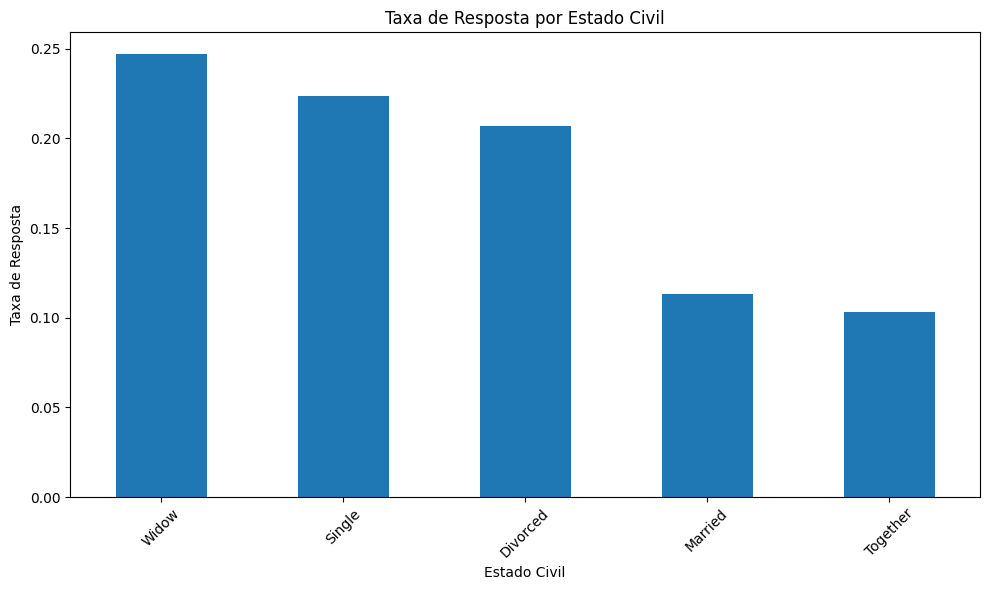

In [3]:
### Para Marital_Status
contingency_marital = pd.crosstab(df['Marital_Status'], df['Response'])
chi2_marital, p_value_marital, dof_marital, expected_marital = chi2_contingency(contingency_marital)

print("Teste Qui-quadrado para Estado Civil")
print(f"p-value: {p_value_marital:.4f}")

### Taxas de resposta por estado civil
response_rates_marital = contingency_marital.div(contingency_marital.sum(axis=1), axis=0)
plt.figure(figsize=(10, 6))
response_rates_marital[1].sort_values(ascending=False).plot(kind='bar')
plt.title('Taxa de Resposta por Estado Civil')
plt.xlabel('Estado Civil')
plt.ylabel('Taxa de Resposta')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Como o p valor deu igual a zero, podemos rejeitar a hipótese nula. Vamos adicionar essa variável no modelo.

Teste Qui-quadrado para Nível Estudo
p-value: 0.0001


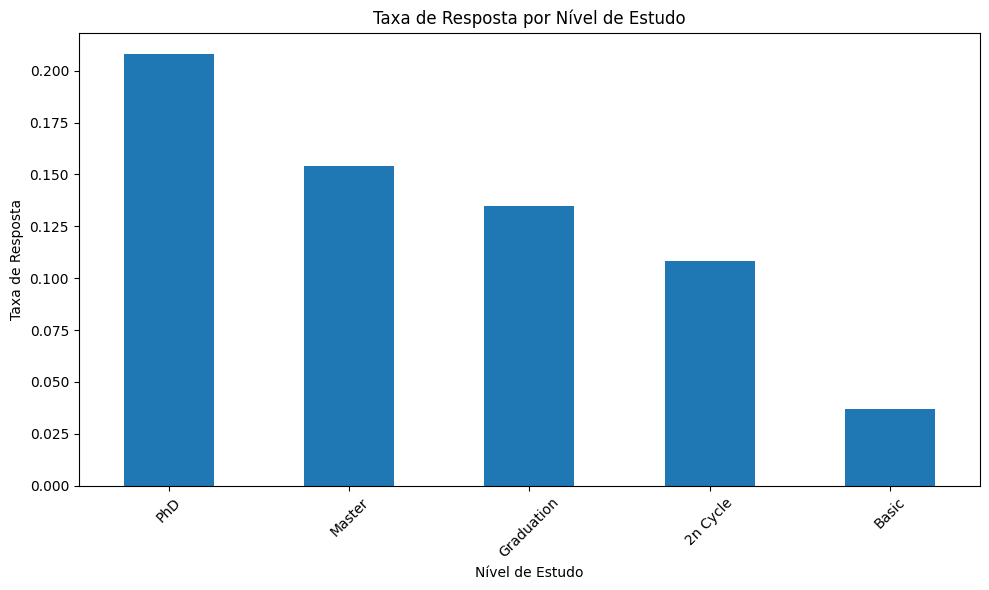

In [4]:
### Para Education
contingency_education = pd.crosstab(df['Education'], df['Response'])
chi2_education, p_value_education, dof_education, expected_education = chi2_contingency(contingency_education)

print("Teste Qui-quadrado para Nível Estudo")
print(f"p-value: {p_value_education:.4f}")

# Visualizar as taxas de resposta por nível de estudo
response_rates_education = contingency_education.div(contingency_education.sum(axis=1), axis=0)
plt.figure(figsize=(10, 6))
response_rates_education[1].sort_values(ascending=False).plot(kind='bar')
plt.title('Taxa de Resposta por Nível de Estudo')
plt.xlabel('Nível de Estudo')
plt.ylabel('Taxa de Resposta')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

O p-valor deu um valor muito pequeno, por isso, podemos rejeitar a hipótese nula e adicionar essa variável, após tratamento, no nosso modelo.

In [5]:
### One-Hot Encoder para tratar as variáveis categóricas

df_encoded = pd.get_dummies(df, 
                          columns=['Marital_Status', 'Education'],
                          prefix=['Marital', 'Edu'])


In [6]:
df_encoded.head().T

,0,1,2,3,4
ID,5524,2174,4141,6182,5324
Year_Birth,1957.0,1954.0,1965.0,1984.0,1981.0
Income,58138.0,46344.0,71613.0,26646.0,58293.0
Kidhome,0,1,0,1,1
Teenhome,0,1,0,0,0
Dt_Customer,2012-09-04,2014-03-08,2013-08-21,2014-02-10,2014-01-19
Recency,58,38,26,26,94
MntWines,635,11,426,11,173
MntFruits,88,1,49,4,43
MntMeatProducts,546,6,127,20,118


## Seleção de Features

Vamos criar uma lista com as features selecionadas para entrar no modelo.

In [7]:
### Seleção de Colunas

select_columns = ['Year_Birth', 'Income', 'Kidhome', 'Teenhome','Recency',
    'MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth', 
    'AcceptedCmp1', 'AcceptedCmp2','AcceptedCmp3','AcceptedCmp4', 'AcceptedCmp5','Customer_Age',
    'Total_Channels_Purchased','Total_Accepted_Cmps', 'Cluster', 
    'Marital_Divorced', 'Marital_Married','Marital_Single', 'Marital_Together', 'Marital_Widow', 
    'Edu_2n Cycle','Edu_Basic', 'Edu_Graduation', 'Edu_Master', 'Edu_PhD','Response']

In [8]:
### Seleção das features
df = df_encoded[select_columns]

features = [f for f in df.columns if f not in ['Response']]

## Normalização

In [9]:
### Colunas numéricas para normalizar

numeric_features = df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()


In [10]:
### Instanciar o transformador

preprocessor = ColumnTransformer(
    transformers=[('num', MinMaxScaler(), numeric_features)],
    remainder='passthrough'  # mantém as colunas binárias inalteradas
)

In [11]:
### Normalização
X_normalized = preprocessor.fit_transform(df[features])

In [12]:
### DataFrame normalizado
df_normalized = pd.DataFrame(X_normalized, columns=features)

## Train Test Split

Vamos separar a base em 30% para teste e 70% para treino.

In [13]:
### Separação da base de treino e teste

X_train, X_test, y_train, y_test = train_test_split(df_normalized,df['Response'], test_size=0.3,random_state=42)
print("Tamanho da Base de Treino: ",X_train.shape)
print("Tamanho da Base de Teste: ",X_test.shape)

Tamanho da Base de Treino:  (1568, 35)
Tamanho da Base de Teste:  (672, 35)


## Seleção do Modelo

Três modelos de classificação seram testados, e o escolhido será o modelo com melhor AUC-ROC.

In [14]:
### Modelos

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
}

In [15]:
### Loop para treinar/avaliar a performance de cada modelo
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    # métrica escolhida AUC_SCORE
    auc_score = roc_auc_score(y_test, y_pred_proba)
    results[name] = auc_score
    print(f'{name} - AUC-ROC: {auc_score:.4f}')

Logistic Regression - AUC-ROC: 0.8800
Random Forest - AUC-ROC: 0.8693
Gradient Boosting - AUC-ROC: 0.8755


In [16]:
### Melhor modelo escolhido
best_model = models['Logistic Regression']
probabilities = best_model.predict_proba(df_normalized)[:,1]

In [17]:
### Adicionando probabilidades ao DataFrame original
df['conversion_probability'] = probabilities

/var/folders/v_/vww_frc97d9c4d1l1l9rshzw0000gn/T/ipykernel_29407/3114635533.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conversion_probability'] = probabilities


## Lucro Máximo

No passo anterior, calculamos as probabilidades usando o melhor modelo selecionado.

Ao escolher um threshold para selecionar essas probabilidades, vamos:
- Ter uma nova quantidade de clientes selecionados
- Ter uma nova taxa de conversão

Aqui, vamos utilizar como premissa que a quantidade de convertidos será a soma das probabilidades. 

Para achar o lucro máximo, vamos testar um range grande de thresholds, e para cada valor, vamos armazenar receita, custo e lucro. 

Com todos os valores de lucro para cada threshold, teremos uma função lucro em função do threshold. Com essa função, conseguimos calcular o lucro máximo.

In [18]:
### Achando o Lucro Máximo
thresholds = np.arange(0.01, 0.99, 0.01) 
results = []
total_customers = len(df)

for threshold in thresholds:
    # Métricas
    selected = df[df['conversion_probability'] >= threshold]
    selected_count = len(selected)
    expected_conversions = selected['conversion_probability'].sum()
    
    # Curva da função Lucro
    receita = expected_conversions * 11
    custo = selected_count * 3
    lucro = receita - custo
    
    results.append({
        'threshold': threshold,
        'selected_count': selected_count,
        'expected_conversions': expected_conversions,
        'receita': receita,
        'custo': custo,
        'lucro': lucro
    })

results_df = pd.DataFrame(results)

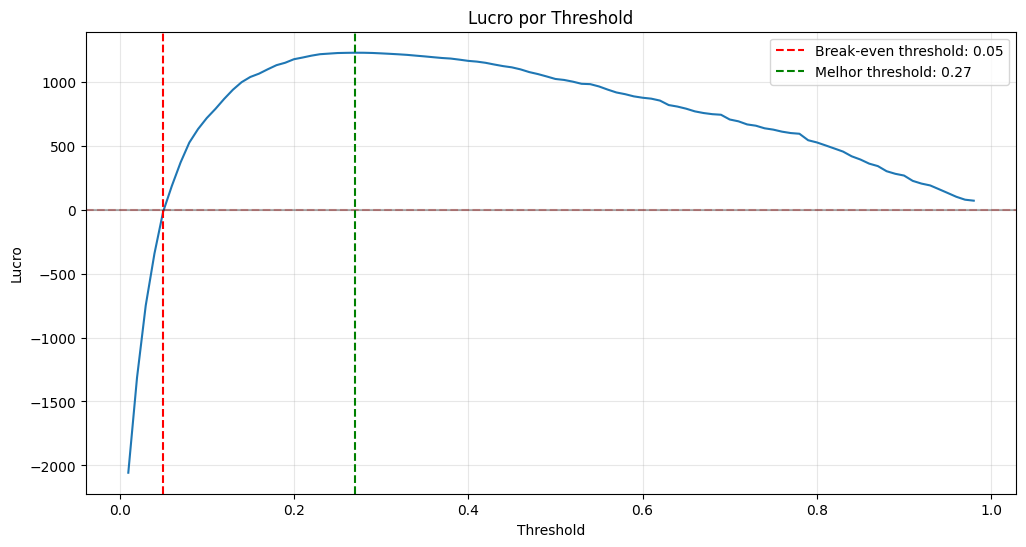


Melhores resultados com threshold = 0.27:
Clientes selecionados: 377.0
% do total: 16.8% da base total
Conversões esperadas: 214
Taxa de conversão: 56.9%
Receita: 2359
Custo: 1131
Lucro: 1228


In [19]:
### Encontrar threshold com maior lucro
best_result = results_df.loc[results_df['lucro'].idxmax()]

# Visualizações
plt.figure(figsize=(12,6))
plt.plot(results_df['threshold'], results_df['lucro'])
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)  # Linha do lucro zero
plt.title('Lucro por Threshold')
plt.xlabel('Threshold')
plt.ylabel('Lucro')

# Encontrar o threshold do break-even
break_even_idx = np.where(np.diff(np.signbit(results_df['lucro'])))[0]
if len(break_even_idx) > 0:
    break_even_threshold = results_df['threshold'].iloc[break_even_idx[0]]
    
    plt.axvline(break_even_threshold, color='r', linestyle='--', 
                label=f'Break-even threshold: {break_even_threshold:.2f}')

plt.axvline(best_result['threshold'], color='g', linestyle='--', 
            label=f'Melhor threshold: {best_result["threshold"]:.2f}')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nMelhores resultados com threshold = {best_result['threshold']:.2f}:")
print(f"Clientes selecionados: {best_result['selected_count']}")
print(f"% do total: {best_result['selected_count']/total_customers*100:.1f}% da base total")
print(f"Conversões esperadas: {best_result['expected_conversions']:.0f}")
print(f"Taxa de conversão: {best_result['expected_conversions']/best_result['selected_count']*100:.1f}%")
print(f"Receita: {best_result['receita']:.0f}")
print(f"Custo: {best_result['custo']:.0f}")
print(f"Lucro: {best_result['lucro']:.0f}")


## Taxa de Conversão por Cluster

In [20]:
### Selecionar clientes acima do threshold escolhido
selected_customers = df[df['conversion_probability'] >= best_result['threshold']]
selected_customers.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Marital_Single,Marital_Together,Marital_Widow,Edu_2n Cycle,Edu_Basic,Edu_Graduation,Edu_Master,Edu_PhD,Response,conversion_probability
0,1957.0,58138.0,0,0,58,635,88,546,172,88,...,True,False,False,False,False,True,False,False,1,0.586879
15,1946.0,82800.0,0,0,23,1006,22,115,59,68,...,True,False,False,False,False,False,False,True,1,0.952135
27,1986.0,51381.5,1,0,19,5,1,3,3,263,...,True,False,False,False,False,True,False,False,0,0.450752
33,1952.0,46610.0,0,2,8,96,12,96,33,22,...,False,False,False,False,False,False,False,True,1,0.385357
34,1946.0,68657.0,0,0,4,482,34,471,119,68,...,False,False,False,False,False,False,True,False,0,0.305877


In [21]:
### Taxa de conversão por cluster para os clientes selecionados
conversion_by_cluster = selected_customers.groupby('Cluster')['Response'].agg([
    'count',  # número de clientes selecionados
    'mean',   # taxa de conversão
]).round(4)

# Porcentagem do total de clientes selecionados
conversion_by_cluster['percent_of_total'] = (conversion_by_cluster['count'] / len(selected_customers) * 100).round(2)
conversion_by_cluster.columns = ['Clientes Selecionados', 'Taxa de Conversão', '% do Total']
conversion_by_cluster = conversion_by_cluster.sort_values('Taxa de Conversão', ascending=False)

print("Análise de Conversão por Cluster:")
print(conversion_by_cluster)



Análise de Conversão por Cluster:
         Clientes Selecionados  Taxa de Conversão  % do Total
Cluster                                                      
3                          130             0.7846       34.48
4                           12             0.5833        3.18
0                           76             0.5263       20.16
1                           41             0.4878       10.88
2                          118             0.4831       31.30


## Recomendações Finais

- Para cumprir o objetivo de obtenção de lucro máximo, com o uso do modelo preditivo, é esperado que a próxima campanha tenha um número reduzido de clientes impactados (diminuição de custo) e um aumento de taxa de conversão. 
<br>
- A expectativa de lucro máximo é de 1228, com um total de 377 clientes selecionados (16.8% da base inicial). 
<br>
- Como sugestão, o time de marketing pode planejar campanhas especializadas por cluster. A análise mostrou que o cluster com maior taxa de conversão é o Cluster Vinho (Premium). 
<br>
- Testes A/B podem ser utilizados para testar se uma comunicação direcionada por cluster traz impacto de conversão.
<br>
- Importante monitorar e atualizar periodicamente a classificação dos clusters.